<a href="https://colab.research.google.com/github/JishnuJayaraj/ML/blob/master/TrendDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# run in shell for getting link for local runtime in GCP
jupyter notebook \
  --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=8888 \
  --NotebookApp.port_retries=0

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nomachine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


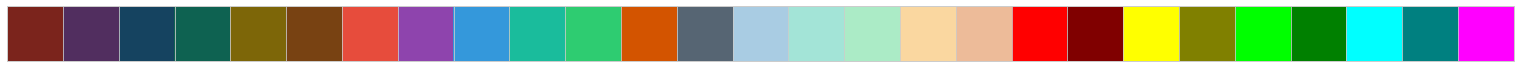

In [115]:
%matplotlib inline
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
import hdbscan
import umap
# from hdbscan import HDBSCAN

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import itertools

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.io import output_notebook ,show, reset_output
import bokeh
from bokeh.plotting import figure
from bokeh.models import HoverTool
from bokeh.plotting import show, save, output_notebook, output_file
import umap.plot

from ipywidgets import interactive
import ipywidgets as widgets



sns.set(font='serif')
sns.set_context("paper") # , font_scale=1.4
# sns.set_style("white")
sns.set_style("whitegrid",{
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

# customPalette = ['#FF0000', "#c77406", '#800000', '#D3500C', '#FFFF00', '#808000', '#00FF00',
#         "#4374B3",'#008000',"#f9ac07", '#00FFFF', '#008080', '#0000FF', '#000080',
#         '#FF00FF', '#800080', '#808080', '#8E44AD', '#48C9B0', '#0E6655', '#52BE80', '#B7950B','#5D6D7E',
#         '#212F3C', '#3498DB', '#BB8FCE', '#F9E79F', '#F0B27A','#F5B7B1', '#A3E4D7']
# , '#1B2631 ' , '#F1C40F ' , '#E6B0AA ' , '#D7BDE2 '

customPalette=['#7B241C', '#512E5F', '#154360', '#0E6251', '#7D6608', '#784212',
               '#E74C3C', '#8E44AD', '#3498DB', '#1ABC9C', '#2ECC71', '#D35400',
               '#566573', '#A9CCE3', '#A3E4D7', '#ABEBC6', '#FAD7A0',
               '#EDBB99', '#FF0000', '#800000', '#FFFF00', '#808000', '#00FF00', '#008000',
               '#00FFFF', '#008080', '#FF00FF']
# plotting hue as probabilities?
sns.palplot(customPalette)

# reading data

In [46]:
# file_name = 'from2019'
file_name = 'from2019_small'

home_path = '~/Documents/TrendDetection/Rokin/'
%cd $home_path

pd.set_option('display.max_colwidth', None)
file_path = home_path + 'datasets/' + file_name + '.pkl'

# data_path = '~/Documents/TrendDetection/Rokin/datasets/from2019.pkl'
df = pd.read_pickle(file_path)
# df.drop(['text','sitename'], axis=1, inplace=True)

print(df.info())
df.sample(5)

/home/nomachine/Documents/TrendDetection/Rokin
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5784 entries, 0 to 5783
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    5784 non-null   datetime64[ns, UTC]
 1   title   5784 non-null   object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 90.5+ KB
None


,date,title
5271,2020-10-14 19:40:58+00:00,Thawing permafrost releases organic compounds into the air
188,2019-01-03 00:00:00+00:00,The Consumer Electronics Hall of Fame: Grundig Satellit 650 Radio
837,2019-04-12 00:00:00+00:00,Hurdle the barriers to energy project savings
2580,2019-11-19 13:01:00+00:00,HoloBuilder Announces Partnership with Boston Dynamics
595,2019-03-12 00:00:00+00:00,Integration of power:communication interfaces in smart true wireless headset designs


In [47]:
# number of articles published over time

# check if days and month were swaped (must be uniformly distributed plot)
# days = df['date'].dt.day
# sns.displot(days, kde= False, bins = 31)
# plt.show()

# plot number of articles Yearwise
columns=['Y','6M','3M', '1M', '2W', '1W']
def g(x):
    df['date'].value_counts().resample(x).sum().plot.line()
    plt.show()

interactive_plot = interactive(g, x=columns)
interactive_plot

interactive(children=(Dropdown(description='x', options=('Y', '6M', '3M', '1M', '2W', '1W'), value='Y'), Outpu…

the longest title length is :  297


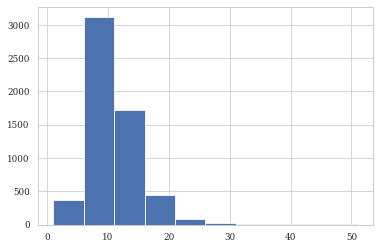

In [52]:
# length of headline, x
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

plot_word_number_histogram(df['title'])
print('the longest title length in character is : ',df['title'].str.len().max())

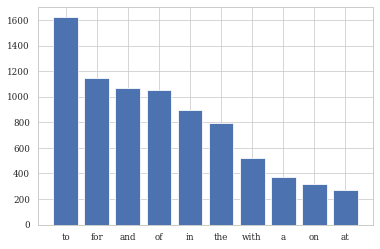

In [54]:
# stop words
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

plot_top_stopwords_barchart(df['title'])

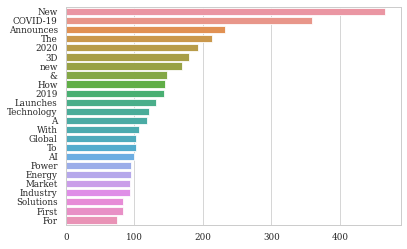

In [55]:
# Code Snippet for Top Non-Stopwords Barchart

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(df['title'])

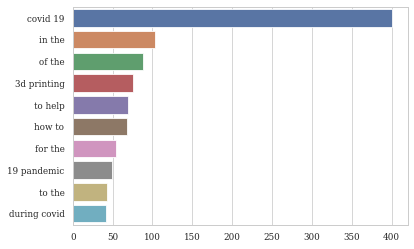

In [57]:
# bi grams
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df['title'],2)

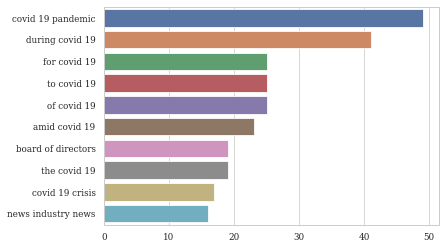

In [58]:
plot_top_ngrams_barchart(df['title'],3)

In [ ]:
#@title slice the date if needed

# df['date'] = df['date'].dt.tz_localize(None)
# df.query('date > "2019-01-01" & date < "2019-01-05"', inplace=True)
# df.query('date < "2020-10-01"', inplace=True)

# sort the index, 0 - n-1, and drop prev index
# df.reset_index(drop=True, inplace=True)
# df.info()

# embedding model

In [59]:
# model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# bi_encoder_path = 'stsb_augsbert_SS_bert-base-uncased-2020-11-20_12-09-45'
bi_encoder_path = '/home/nomachine/Documents/TrendDetection/Rokin/output/bi-encoder/stsb_augsbert_SS_bert-base-uncased-2020-11-20_12-09-45'
bi_encoder = SentenceTransformer(bi_encoder_path)

In [ ]:
#@title UST model

# import tensorflow as tf
# import tensorflow_hub as hub

# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# bi_encoder = hub.load(module_url)

In [60]:
# ENCODING sentence to vector

data = df.title.to_list()

train_embeddings = bi_encoder.encode(data, show_progress_bar=True)
# train_embeddings = model.encode(df.title)
train_embeddings.shape

(5784, 768)

# dimensionality reduction and parameter tuning

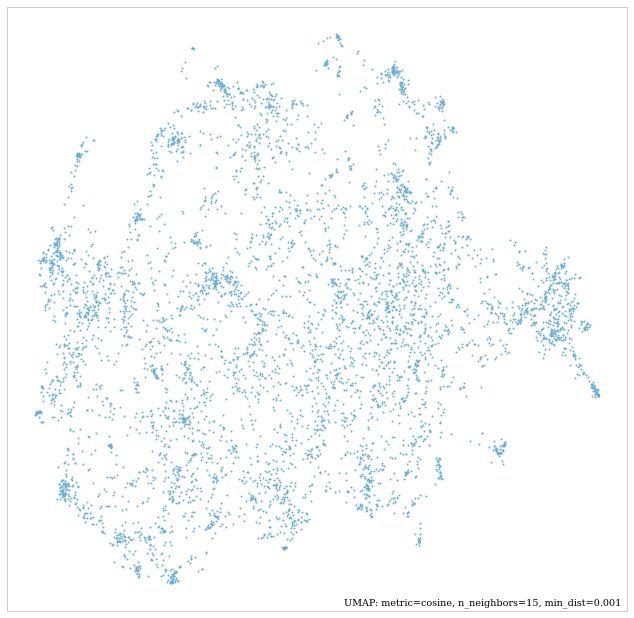

In [61]:
# UMAP
Umap2d = umap.UMAP(n_neighbors=15,spread=1, min_dist=0.001,n_components=2,random_state=42,metric='cosine')
# HDBSCAN
clusterer2d = hdbscan.HDBSCAN(min_samples=12,min_cluster_size=25)

# for umap visualization
mapper2d = Umap2d.fit(train_embeddings)   # # ----

# for hdbscan
embedding2d = Umap2d.fit_transform(train_embeddings)
clusterer2d.fit(embedding2d)

# view umap embedding
p = umap.plot.points(mapper2d)

In [62]:
# result for 2d embedding clustering
labels = clusterer2d.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print(set(labels))
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(embedding2d, labels))

Estimated number of clusters: 36
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, -1}
Estimated number of noise points: 1740
Silhouette Coefficient: 0.043


In [65]:
# Actual umap run (decided on pure visualization of 2d embedding)

clusterable_embedding = umap.UMAP(n_neighbors=15,min_dist=0.001,
                                  n_components=5,random_state=42,metric='cosine').fit_transform(train_embeddings)

clusterable_embedding.shape

(5784, 5)

### save the embeddings

In [7]:
import joblib
# !mkdir embeddings
joblib_file = "embeddings/joblib_embedding64.pkl"
joblib.dump(clusterable_embedding, joblib_file)

['embeddings/joblib_embedding64.pkl']

In [ ]:
# laoding saved embedding
import joblib
from collections import Counter
import pandas as pd
import numpy as np
%matplotlib inline
import hdbscan
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interactive

home_path = '~/Documents/TrendDetection/Rokin/'
%cd $home_path

joblib_file = "~/home/Documents/TrendDetection/Rokin/embeddings/joblib_embedding64.pkl"
clusterable_embedding = joblib.load(joblib_file)

## hyper parameter

In [66]:
# finding min samples relation to noise  (clusterable_embedding)
scores = []
min_pts = []

# loop through min samples
for i in range(5,25):

  clusterer_hyper = hdbscan.HDBSCAN(min_samples=i,min_cluster_size=25)
  clusterer_hyper.fit(clusterable_embedding)
  
  all_prob = clusterer_hyper.probabilities_

  # Count odd numbers in the list
  count_niche = sum(map(lambda x : x <= 0.5, all_prob))

  # fraction with low confid
  score = count_niche/len(all_prob)

  scores.append(score)
  min_pts.append(i)

percentile_list = pd.DataFrame(np.column_stack([min_pts, scores]),columns=['min_Pts', 'Scores'])
# index = percentile_list['Scores'].idxmin()
# row = percentile_list.iloc[index]
# print('The optimum value of min_pts is : ', row[0])


output_notebook()

line_plot = figure(plot_width =500, plot_height=325, title='Noice ratio for different min_samples',x_axis_label='x', y_axis_label='y')
line_plot.line(percentile_list['min_Pts'],percentile_list['Scores'],legend='line', line_width=2)

line_plot.add_tools(HoverTool())

show(line_plot)
# at very low value all points clustered, at high big chunk => middle low

Loading BokehJS ...

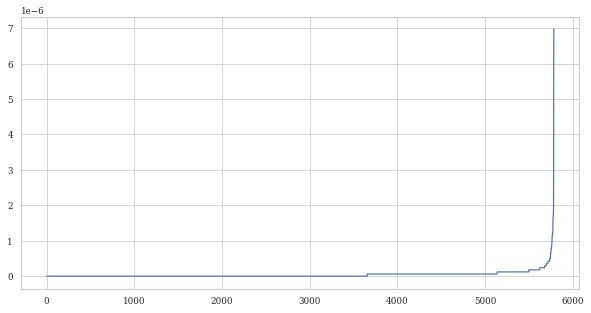

In [67]:
# finding epsilon with nn distance  (use embedding2d)
from sklearn.neighbors import NearestNeighbors

plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=3, metric = 'cosine').fit(embedding2d)
distances, idx = nn.kneighbors(embedding2d)
distances = np.sort(distances, axis=0)
distances = distances[:,2]
plt.plot(distances)
plt.show()

In [70]:
# loop thr all posible values, clusterable_embedding

eps_values = np.arange(0.0,2.6,0.2)
min_samples = np.arange(10,16)
mcluster_size= np.arange(15,20) #

hdbscan_params = list(itertools.product(eps_values, min_samples, mcluster_size)) #

no_of_clusters = []
sil_score = []
dav_score =[]
noise = [] #
epsvalues = []
min_samp = []
min_clus = []

for (p,q,r) in hdbscan_params:
    hdbscan_cluster = hdbscan.HDBSCAN(min_samples=int(q),
                                         min_cluster_size = int(r),
                                         cluster_selection_epsilon=float(p)).fit(clusterable_embedding)
    epsvalues.append(p)
    min_samp.append(q)
    min_clus.append(r)
    no_of_clusters.append(len(np.unique(hdbscan_cluster.labels_))) #
    noise.append(list(hdbscan_cluster.labels_).count(-1))
    sil_score.append(silhouette_score(clusterable_embedding, hdbscan_cluster.labels_))
    dav_score.append(davies_bouldin_score(clusterable_embedding, hdbscan_cluster.labels_))

hyperList = list(zip(no_of_clusters, min_clus, epsvalues, min_samp, noise, dav_score, sil_score))
hyper_df = pd.DataFrame(hyperList, columns=['no_of_clusters', 'min_cluster_size', 'epsilon_values', 'minimum_points', 'noise', 'david_bould_score', 'silhouette_score'])
hyper_df.to_csv('parameters.csv')
hyper_df


,no_of_clusters,min_cluster_size,epsilon_values,minimum_points,noise,david_bould_score,silhouette_score
0,63,15,0.0,10,2228,1.064577,0.058533
1,62,16,0.0,10,2209,1.067948,0.060601
2,59,17,0.0,10,2257,1.064654,0.052849
3,54,18,0.0,10,2208,1.078458,0.057995
4,52,19,0.0,10,2179,1.085809,0.065718
...,...,...,...,...,...,...,...
385,3,15,2.4,15,58,4.573344,0.018450
386,3,16,2.4,15,58,4.573344,0.018450
387,3,17,2.4,15,58,4.573344,0.018450
388,3,18,2.4,15,58,4.573344,0.018450


## flat clustering

### imports

In [79]:
def HDBSCAN_flat(X, n_clusters=None,
                 cluster_selection_epsilon=0.,
                 clusterer=None, inplace=False, **kwargs):
    """
    Train a HDBSCAN clusterer by specifying n_clusters.
    Or, modify a trained clusterer to return specific n_clusters.
    Parameters
    ----------
    X: array-like
        Data to be passed to HDBSCAN for training.
    n_clusters: int, default=None
        Number of clusters to produce.
        If None, revert to default HDBSCAN
    cluster_selection_epsilon: float, default=0.
        core-distance below which to stop splitting clusters.
        This can indirectly impose n_clusters.
        This argument is ignored if n_clusters is supplied.
    clusterer: HDBSCAN, default=None
        If supplied, modify this clusterer to produce n_clusters clusters.
    inplace: bool, default=False
        If 'clusterer' parameter is supplied, and inplace is True,
            modify the previous clusterer inplace.
            If False, return a modified copy of the previous clusterer.
    **kwargs: keyword arguments
        All init arguments for HDBSCAN
    Returns
    -------
    new_clusterer: HDBSCAN
        New HDBSCAN instance; returned irrespective of inplace=True or False
    Usage
    -----
    # Extract flat clustering from HDBSCAN's hierarchy for 7 clusters
    clusterer = HDBSCAN_flat(X_train, n_clusters=7,
                             min_cluster_size=12, min_samples=8)
    labels = clusterer.labels_
    proba = clusterer.probabilities_
    # Use a previously initialized/trained HDBSCAN
    old_clusterer = HDBSCAN(min_cluster_size=12, min_samples=8)
    clusterer = HDBSCAN_flat(X_train, n_clusters=7,
                             clusterer=old_clusterer, inplace=True)
    labels = clusterer.labels_
    proba = clusterer.probabilities_
    See Also
    ---------
    :py:func:`hdbscan.HDBSCAN`
    :py:func:`re_init`
    """
    # Handle the trivial case first.
    if (n_clusters is None) and (cluster_selection_epsilon == 0.):
        if (not isinstance(clusterer, HDBSCAN)) or (not inplace):
            # Always generate prediction_data to avoid later woes
            kwargs['prediction_data'] = True
            new_clusterer = HDBSCAN(**kwargs)
        else:
            new_clusterer = clusterer
            new_clusterer.prediction_data = True

        new_clusterer.fit(X)
        return new_clusterer

    if (n_clusters is not None) and (cluster_selection_epsilon != 0.):
        warn(f"'cluster_selection_epsilon' (={cluster_selection_epsilon})"
             f" is ignored when 'n_clusters' is supplied.")
        cluster_selection_epsilon = 0.
        # This will later be chosen according to n_clusters

    if not isinstance(clusterer, HDBSCAN):
        # Initialize and train clusterer if one was not previously supplied.
        # Always generate prediction data
        kwargs['prediction_data'] = True
        new_clusterer = HDBSCAN(**kwargs)
        # We do not pass cluster_selection_epsilon here.
        # While this adds unnecessary computation, it makes the code
        #   easier to read and debug.
        new_clusterer.fit(X)
    else:
        if inplace:
            new_clusterer = clusterer
        else:
            new_clusterer = copy.deepcopy(clusterer)

        new_clusterer.prediction_data = True

        # Train on 'X'. Do this even if the supplied clusterer was trained,
        #   because we want to make sure it fits 'X'.
        new_clusterer.prediction_data = True
        new_clusterer.fit(X)

    if new_clusterer.cluster_selection_method == 'eom':
        max_eom_clusters = len(
                new_clusterer.condensed_tree_._select_clusters())

    # Pick an epsilon value right after a split produces n_clusters,
    #   and the don't split further for smaller epsilon (larger lambda)
    if n_clusters is not None:
        if ((new_clusterer.cluster_selection_method == 'eom') and
                (n_clusters > max_eom_clusters)):
            warn(f"Cannot predict more than {max_eom_clusters} with cluster "
                 "selection method 'eom'. Changing to method 'leaf'...")
            new_clusterer.cluster_selection_method = 'leaf'
        epsilon = select_epsilon(new_clusterer.condensed_tree_, n_clusters)
    else:
        # Or use the specified cluster_selection_epsilon
        epsilon = cluster_selection_epsilon

    new_clusterer.cluster_selection_epsilon = float(epsilon)

    # Extract tree related stuff, in order to re-assign labels
    single_linkage_tree = new_clusterer.single_linkage_tree_
    single_linkage_tree = single_linkage_tree.to_numpy()
    min_cluster_size = new_clusterer.min_cluster_size
    cluster_selection_method = new_clusterer.cluster_selection_method
    allow_single_cluster = new_clusterer.allow_single_cluster
    match_reference_implementation = False

    # Get labels according to the required cluster_selection_epsilon
    output = _tree_to_labels(
                        None,
                        single_linkage_tree, min_cluster_size,
                        cluster_selection_method,
                        allow_single_cluster,
                        match_reference_implementation,
                        cluster_selection_epsilon=epsilon)

    # Reflect the related changes in HDBSCAN.
    (new_clusterer.labels_,
     new_clusterer.probabilities_,
     new_clusterer.cluster_persistence_,
     new_clusterer._condensed_tree,
     new_clusterer._single_linkage_tree) = output

    # PredictionData attached to HDBSCAN should also change.
    # A function re_init is defined in this module to handle this.
    re_init(new_clusterer.prediction_data_,
            new_clusterer.condensed_tree_,
            cluster_selection_epsilon=epsilon)
    return new_clusterer


def approximate_predict_flat(clusterer,
                             points_to_predict,
                             n_clusters=None,
                             cluster_selection_epsilon=None,
                             prediction_data=None,
                             return_prediction_data=False):
    """
    Predict the cluster label of new points at a particular flat clustering,
        specified by n_clusters. This is a modified version of
        hdbscan.approximate_predict to allow selection of n_clusters.
    Parameters
    ----------
    clusterer : HDBSCAN
        A clustering object that has been fit to the data and
        either had ``prediction_data=True`` set, or called the
        ``generate_prediction_data`` method after the fact.
    points_to_predict : array, or array-like (n_samples, n_features)
        The new data points to predict cluster labels for. They should
        have the same dimensionality as the original dataset over which
        clusterer was fit.
    n_clusters: int, default=None
        The number of clusters to have in the flat clustering
            (over the training data, not points_to_predict)
        Ignored when prediction_data is supplied.
    cluster_selection_epsilon: float, default=None
        core-distance below which to stop splitting clusters.
        This can indirectly impose n_clusters.
        This argument is ignored if n_clusters is supplied.
    prediction_data: PredictionData, default=None
        If supplied, use this to predict clusters for points_to_predict.
        This allows predicting on multiple datasets without corrupting
            prediction data associated with clusterer.
        If neither n_clusters, nor prediction_data are supplied,
            then the prediction_data associated with clusterer is used.
    return_prediction_data: bool, default=False
        If True, return prediction_data along with labels and proba.
    Returns
    -------
    labels : array (n_samples,)
        The predicted labels of the ``points_to_predict``
    probabilities : array (n_samples,)
        The soft cluster scores for each of the ``points_to_predict``
    prediction_data: PredictionData, optional
        prediction_data used to predict.
        Returned if return_prediciton_data is set to True.
    Usage
    -----
    # From a fitted HDBSCAN model, predict for n_clusters=5
    labels, proba = approximate_predict_flat(
                        clusterer, X_predict, n_clusters=5)
    # Store prediciton data for later use.
    labels, proba, pred_data = approximate_predict_flat(
                                    clusterer, X_predict, n_clusters=5,
                                    return_prediction_data=True)
    # and use this prediction data to predict on new points
    labels1, proba1 = approximate_predict_flat(
                                    clusterer, X_pred1,
                                    prediction_data=pred_data)
    See Also
    ---------
    :py:func:`hdbscan.prediction.approximate_predict`
    """
    # Get number of fitted clusters for later use.
    n_clusters_fit = np.sum(np.unique(clusterer.labels_) >= 0)
    if n_clusters is not None:
        n_clusters = int(n_clusters)  # Ensure n_clusters is int

    # We'll need the condensed tree later...
    condensed_tree = clusterer.condensed_tree_

    # If none of the three arguments: prediction_data, n_clusters,
    #   and cluster_selection_epsilon are supplied,
    # then use clusterer's prediciton data directly
    if ((prediction_data is None) and
            ((n_clusters is None) or (n_clusters == n_clusters_fit)) and
            (cluster_selection_epsilon is None)):
        prediction_data = clusterer.prediction_data_

    # If either of n_clusters or cluster_selection_epsilon were supplied,
    #   then build prediction data from these by modifying clusterer's
    if not isinstance(prediction_data, PredictionData):
        if clusterer.prediction_data_ is None:
            raise ValueError(
                    'Clusterer does not have prediction data!'
                    ' Try fitting with prediction_data=True set,'
                    ' or run generate_prediction_data on the clusterer')
        # Get prediction data from clusterer
        prediction_data = clusterer.prediction_data_
        # Modify prediction_data to reflect new n_clusters
        # First, make a copy of prediction data to avoid modifying source
        prediction_data = copy.deepcopy(prediction_data)
        # Cluster selection method is hold by condensed_tree.
        # Change from 'eom' to 'leaf' if n_clusters is too large.
        if ((condensed_tree.cluster_selection_method == 'eom') and (
                (n_clusters is not None) and (n_clusters > n_clusters_fit))):
            warn(f"Cannot predict more than {n_clusters_fit} with cluster "
                 "selection method 'eom'. Changing to method 'leaf'...")
            condensed_tree.cluster_selection_method = 'leaf'
        # This change does not affect the tree associated with 'clusterer'
        # Re-initialize prediction_data for the specified n_clusters or epsilon
        re_init(prediction_data, condensed_tree,
                n_clusters=n_clusters,
                cluster_selection_epsilon=cluster_selection_epsilon)

    # ============================================================
    # Now we're ready to use prediction_data
    # The rest of the code is copied from HDBSCAN's approximate_predict,
    #   but modified to use prediction_data instead of clusterer's attribute
    points_to_predict = np.asarray(points_to_predict)

    if points_to_predict.shape[1] != prediction_data.raw_data.shape[1]:
        raise ValueError('New points dimension does not match fit data!')

    if prediction_data.cluster_tree.shape[0] == 0:
        warn('Prediction data does not have any defined clusters, new data'
             ' will be automatically predicted as noise.')
        labels = -1 * np.ones(points_to_predict.shape[0], dtype=np.int32)
        probabilities = np.zeros(points_to_predict.shape[0], dtype=np.float32)
        if return_prediction_data:
            return labels, probabilities, prediction_data
        else:
            return labels, probabilities

    labels = np.empty(points_to_predict.shape[0], dtype=np.int)
    probabilities = np.empty(points_to_predict.shape[0], dtype=np.float64)

    min_samples = clusterer.min_samples or clusterer.min_cluster_size
    neighbor_distances, neighbor_indices = prediction_data.tree.query(
                                              points_to_predict,
                                              k=2 * min_samples)

    for i in range(points_to_predict.shape[0]):
        label, prob = _find_cluster_and_probability(
            condensed_tree,
            prediction_data.cluster_tree,
            neighbor_indices[i],
            neighbor_distances[i],
            prediction_data.core_distances,
            prediction_data.cluster_map,
            prediction_data.max_lambdas,
            min_samples
        )
        labels[i] = label
        probabilities[i] = prob

    if return_prediction_data:
        return labels, probabilities, prediction_data
    else:
        return labels, probabilities



In [81]:
def membership_vector_flat(
        clusterer, points_to_predict,
        prediction_data=None, n_clusters=None,
        cluster_selection_epsilon=0.):
    """
    (Adaptation of hdbscan's membership_vector for n_clusters, epsilon)
    Predict soft cluster membership probabilities;
        a vector for each point in ``points_to_predict`` that gives
        a probability that the given point is a member of a cluster
        for each of the selected clusters of the ``clusterer``.
    Parameters
    ----------
    clusterer: HDBSCAN
        A clustering object that has been fit to the data and
        either had ``prediction_data=True`` set, or called the
        ``generate_prediction_data`` method after the fact.
    points_to_predict: array, or array-like (n_samples, n_features)
        The new data points to predict cluster labels for. They should
        have the same dimensionality as the original dataset over which
        clusterer was fit.
    prediction_data: PredictionData, default=None
        Prediction data associated with HDBSCAN for some flat clustering
    n_clusters: int, default=None
        Number of clusters over which to compute membership probabilities.
        These clusters are obtained as a flat clustering at some
            cluster_selection_epsilon.
    cluster_selection_epsilon: float, default=0.
        core-distance below which to stop splitting clusters.
        This can indirectly impose n_clusters.
        This argument is ignored if n_clusters is supplied.
    Note: If neither n_clusters nor cluster_selection_epsilon are supplied,
        the clusterer's original clustering is used.
    Returns
    -------
    membership_vectors : array (n_samples, n_clusters)
        The probability that point ``i`` is a member of cluster ``j`` is
        in ``membership_vectors[i, j]``.
    See Also
    --------
    :py:func:`hdbscan.predict.membership_vector`
    :py:func:`hdbscan.predict.all_points_membership_vectors`
    """
    points_to_predict = points_to_predict.astype(np.float64)
    # Extract condensed tree for later use
    condensed_tree = clusterer.condensed_tree_

    # Choose flat clustering based on cluster_selection_epsilon or n_clusters.
    # If neither is specified, use clusterer's cluster_selection_epsilon
    if ((n_clusters is None) and
            (cluster_selection_epsilon == 0.) and
            (prediction_data is None)):
        epsilon = clusterer.cluster_selection_epsilon
        # Use the same prediction_data as clusterer's
        prediction_data = clusterer.prediction_data_
    elif prediction_data is None:
        if n_clusters is not None:
            # Compute cluster_selection_epsilon so that a flat clustering
            #   produces a specified number of n_clusters
            # With method 'eom', we may fail to get 'n_clusters' clusters. So,
            try:
                epsilon = select_epsilon(condensed_tree, n_clusters)
            except AssertionError:
                warn(f"Failed to predict {n_clusters} clusters with "
                     "cluster selection method 'eom'. Switching to 'leaf'...")
                condensed_tree.cluster_selection_method = 'leaf'
                epsilon = select_epsilon(condensed_tree, n_clusters)
        else:
            epsilon = cluster_selection_epsilon
        # Create another instance of prediction_data that is consistent
        #   with the selected value of epsilon.
        prediction_data = copy.deepcopy(clusterer.prediction_data_)
        re_init(prediction_data, condensed_tree,
                cluster_selection_epsilon=epsilon)

    # Flat clustering from prediction data
    clusters = clusters_from_prediction_data(prediction_data)

    # Initialize probabilities
    result = np.empty((points_to_predict.shape[0], clusters.shape[0]),
                      dtype=np.float64)

    # k-NN for prediciton points to training set
    min_samples = clusterer.min_samples or clusterer.min_cluster_size
    neighbor_distances, neighbor_indices = \
        prediction_data.tree.query(points_to_predict,
                                   k=2*min_samples)

    # Loop over prediction points to compute probabilities
    for i in range(points_to_predict.shape[0]):
        # We need to find where in the tree the new point would go
        # for the purposes of outlier membership approximation
        nearest_neighbor, lambda_ = \
            _find_neighbor_and_lambda(
                neighbor_indices[i],
                neighbor_distances[i],
                prediction_data.core_distances,
                min_samples)

        # Find row in tree where nearest neighbor drops out,
        #   so we can get a lambda value for the nearest neighbor
        neighbor_tree_row = get_tree_row_with_child(
                    condensed_tree._raw_tree, nearest_neighbor)

        # Assign lambda as min(lambda-to-neighbor, neighbor's-lambda-to-tree)
        # Equivalently, this assigns core distance for prediction point as
        #   max(dist-to-neighbor, neighbor's-dist-to-tree)
        if neighbor_tree_row['lambda_val'] <= lambda_:
            lambda_ = neighbor_tree_row['lambda_val']

        # Probabilities based on distance to closest exemplar in each cluster:
        # Use new prediction_data that points to exemplars that are specific
        #   to the choice of n_clusters
        distance_vec = dist_membership_vector(
            points_to_predict[i],
            prediction_data.exemplars,
            prediction_data.dist_metric)
        # Probabilities based on how long the nearest exemplar persists in
        #   each cluster (with respect to most persistent exemplar)
        # Use new clusters that are defined by the choice of n_clusters.
        outlier_vec = outlier_membership_vector(
            nearest_neighbor,
            lambda_,
            clusters,
            condensed_tree._raw_tree,
            prediction_data.leaf_max_lambdas,
            prediction_data.cluster_tree)

        # Merge the two probabilities to produce a single set of probabilities
        result[i] = distance_vec ** 0.5 * outlier_vec ** 2.0
        result[i] /= result[i].sum()

        # Include probability that the nearest neighbor belongs to a cluster
        result[i] *= prob_in_some_cluster(
            nearest_neighbor,
            lambda_,
            clusters,
            condensed_tree._raw_tree,
            prediction_data.leaf_max_lambdas,
            prediction_data.cluster_tree)

    # Rename variable so it's easy to understand what's being returned
    membership_vectors = result
    return membership_vectors

def all_points_membership_vectors_flat(
        clusterer, prediction_data=None,
        n_clusters=None, cluster_selection_epsilon=None):
    """
    (Adaptation of hdbscan's all_points_membership_vector
        for n_clusters, epsilon)
    Predict soft cluster membership vectors for all points in the
    original dataset the clusterer was trained on. This function is more
    efficient by making use of the fact that all points are already in the
    condensed tree, and processing in bulk.
    Parameters
    ----------
    clusterer : HDBSCAN
         A clustering object that has been fit to the data and
        either had ``prediction_data=True`` set, or called the
        ``generate_prediction_data`` method after the fact.
        This method does not work if the clusterer was trained
        with ``metric='precomputed'``.
    prediction_data: PredictionData, default=None
        Prediction data associated with HDBSCAN for some flat clustering
    n_clusters: int, optional, default=None
        Number of clusters over which to compute membership probabilities.
        These clusters are obtained as a flat clustering at some
            cluster_selection_epsilon.
    cluster_selection_epsilon: float, optional, default=None
        core-distance below which to stop splitting clusters.
        This can indirectly impose n_clusters.
        This argument is ignored if n_clusters is supplied.
    Note: If neither n_clusters nor cluster_selection_epsilon are supplied,
        the clusterer's original clustering is used.
    Returns
    -------
    membership_vectors : array (n_samples, n_clusters)
        The probability that point ``i`` of the original dataset is a member of
        cluster ``j`` is in ``membership_vectors[i, j]``.
    See Also
    --------
    :py:func:`hdbscan.prediction.all_points_membership_vectors`
    :py:func:`hdbscan.prediction.membership_vector`
    """
    # Extract condensed tree for later use
    condensed_tree = clusterer.condensed_tree_

    # Choose flat clustering based on cluster_selection_epsilon or n_clusters.
    # If neither is specified, use clusterer's cluster_selection_epsilon
    if (n_clusters is None) and (cluster_selection_epsilon is None):
        epsilon = clusterer.cluster_selection_epsilon
        # Use the same prediction_data as clusterer's
        prediction_data = clusterer.prediction_data_
    elif prediction_data is None:
        if n_clusters is not None:
            # Compute cluster_selection_epsilon so that a flat clustering
            #   produces a specified number of n_clusters
            # With method 'eom', we may fail to get 'n_clusters' clusters. So,
            try:
                epsilon = select_epsilon(condensed_tree, n_clusters)
            except AssertionError:
                warn(f"Failed to predict {n_clusters} clusters with "
                     "cluster selection method 'eom'. Switching to 'leaf'...")
                condensed_tree.cluster_selection_method = 'leaf'
                epsilon = select_epsilon(condensed_tree, n_clusters)
        else:
            epsilon = cluster_selection_epsilon
        # Create another instance of prediction_data that is consistent
        #   with the selected value of epsilon.
        prediction_data = copy.deepcopy(clusterer.prediction_data_)
        re_init(prediction_data, condensed_tree,
                cluster_selection_epsilon=epsilon)

    # Flat clustering at the chosen epsilon from prediction_data
    clusters = clusters_from_prediction_data(prediction_data)

    all_points = prediction_data.raw_data

    # When no clusters found, return array of 0's
    if clusters.size == 0:
        return np.zeros(all_points.shape[0])

    # Probabilities based on distance to closest exemplar in each cluster:
    # Use new prediction_data that points to exemplars that are specific
    #   to the choice of n_clusters
    distance_vecs = all_points_dist_membership_vector(
        all_points,
        prediction_data.exemplars,
        prediction_data.dist_metric)

    # Probabilities based on how long the point persists in
    #   each cluster (with respect to most persistent exemplar)
    # Use new clusters that are defined by the choice of n_clusters.
    outlier_vecs = all_points_outlier_membership_vector(
        clusters,
        condensed_tree._raw_tree,
        prediction_data.leaf_max_lambdas,
        prediction_data.cluster_tree)

    # Include probability that the point belongs to a cluster
    in_cluster_probs = all_points_prob_in_some_cluster(
        clusters,
        condensed_tree._raw_tree,
        prediction_data.leaf_max_lambdas,
        prediction_data.cluster_tree)

    # Aggregate the three probabilities to produce membership vectors
    result = distance_vecs * outlier_vecs
    row_sums = result.sum(axis=1)
    result = result / row_sums[:, np.newaxis]
    result *= in_cluster_probs[:, np.newaxis]

    # Re-name variable to clarify what's being returned.
    membership_vectors = result
    return membership_vectors


def select_epsilon(condensed_tree, n_clusters):
    """
    Pick optimal epsilon from condensed tree based on n_clusters,
        calls functions specific to 'eom' or 'leaf' selection methods
    """
    cluster_selection_method = condensed_tree.cluster_selection_method
    if cluster_selection_method == 'eom':
        return select_epsilon_eom(condensed_tree, n_clusters)
    if cluster_selection_method == 'leaf':
        return select_epsilon_leaf(condensed_tree, n_clusters)
    raise ValueError('Invalid Cluster Selection Method: %s\n'
                     'Should be one of: "eom", "leaf"\n')


def select_epsilon_eom(condensed_tree, n_clusters):
    """
    Select epsilon so that persistence-based clustering,
        after truncating the tree at the above epsilon,
        has exactly 'n_clusters' clusters
    """
    # With method 'eom', max clusters are produced for epsilon=0,
    #   as computed by
    eom_base_clusters = condensed_tree._select_clusters()
    max_clusters = len(eom_base_clusters)
    # Increasing epsilon can only reduce the number of ouput clusters.

    assert n_clusters <= max_clusters, (
            f"Cannot produce more than {max_clusters} with method 'eom'. " +
            "Use method 'leaf' instead to extract flat clustering.")

    tree = condensed_tree._raw_tree
    # To select epsilon, consider all values where clusters are split
    cluster_lambdas = tree['lambda_val'][tree['child_size'] > 1]
    candidate_epsilons = 1./np.unique(cluster_lambdas) - 1.e-12
    # Subtract the extra e-12 to avoid numerical errors in comparison
    # Then, we avoid splitting for all epsilon below this.
    candidate_epsilons = np.sort(candidate_epsilons)[::-1]

    for epsilon in candidate_epsilons:
        sel_clusters = _new_select_clusters(condensed_tree, epsilon)
        if len(sel_clusters) == n_clusters:
            break
    else:
        raise RuntimeError("Could not find epsilon")

    return epsilon


def select_epsilon_leaf(condensed_tree, n_clusters):
    """
    Select epsilon so that the leaves of condensed tree,
        after truncating at the above epsilon,
        has exactly 'n_clusters' clusters
    """
    # Use an epsilon value that produces the right number of clusters.
    # The condensed tree of HDBSCAN has this information.
    # Extract the lambda levels (=1/distance) from the condensed tree
    lambdas = condensed_tree._raw_tree['lambda_val']
    # We don't want values that produce a large cluster and
    #   just one or two individual points.
    child_sizes = condensed_tree._raw_tree['child_size']
    child_sizes = child_sizes.astype(int)
    # Keep only those lambda values corresponding to cluster separation;
    #   i.e., with child_sizes > 1
    lambdas = lambdas[child_sizes > 1]
    # Get the unique values, because when two clusters fall out of one,
    #   the entry with lambda is repeated.
    lambdas = np.unique(lambdas.astype(float))
    if n_clusters > len(lambdas) + 1:
        warn(f"HDBSCAN can only compute {len(lambdas)+1} clusters. "
             f"Setting n_clusters to {len(lambdas)+1}...")
        n_clusters = len(lambdas) + 1

    # lambda values are sorted by np.unique.
    # Now, get epsilon (distance threshold) as 1/lambda
    epsilon = 1./lambdas[n_clusters-2]
    # At this epsilon, n_clusters have been split.
    # Stop splits at epsilons smaller than this.
    # To allow for numerical errors,
    return epsilon - 1.e-12


def re_init(predData, condensed_tree,
            n_clusters=None, cluster_selection_epsilon=0.):
    """
    Modify PredictionData of HDBSCAN to account for epsilon.
    epsilon is the cluster_selection_epsilon that controls granularity
        of clusters; Large epsilon => More clusters
    Parameters
    ----------
    predData: PredictionData
        Contains data to use for predicting novel points.
        Defined in the HDBSCAN module
    condensed_tree: CondensedTree
        Tree structure that contains hierarchical clustering.
        Defined in the HDBSCAN module
    n_clusters: int, optional, default=None
        If specified, use this to obtain cluster_selection_epsilon
            from CondensedTree; Overrides cluster_selection_epsilon parameter
    cluster_selection_epsilon: float, default=0.
        In cluster tree, nodes are not split further beyond (>=) this value.
        epsilon is the inverse of core distance.
    Returns
    -------
    None
    """
    # predData must be a pre-trained PredictionData instance from hdbscan
    # If n_clusters is specified, compute cluster_selection_epsilon;
    if (n_clusters is not None):
        cluster_selection_epsilon = select_epsilon(condensed_tree, n_clusters)

    # This is the key modification:
    # Select clusters according to selection method and epsilon.
    selected_clusters = _new_select_clusters(condensed_tree,
                                             cluster_selection_epsilon)
    # _new_select_clusters is a modification of get_clusters
    #   from hdbscan._hdbscan_tree

    # raw tree, used later to get exemplars and lambda values
    raw_condensed_tree = condensed_tree._raw_tree

    # Re-do the cluster map: Map cluster numbers in tree (N, N+1, ..)
    #    to the cluster labels produced as output
    predData.cluster_map = {int(c): n for n, c in
                            enumerate(sorted(list(selected_clusters)))}
    predData.reverse_cluster_map = {n: c for c, n in
                                    predData.cluster_map.items()}

    # Re-compute lambdas and exemplars for selected clusters;
    predData.max_lambdas = {}
    predData.exemplars = []

    for cluster in selected_clusters:
        # max_lambda <=> smallest distance <=> most persistent point(s)
        predData.max_lambdas[cluster] = \
                    raw_condensed_tree['lambda_val'][
                        raw_condensed_tree['parent'] == cluster].max()

        # Map all sub-clusters of selected cluster to the selected cluster's
        #       label in output.
        # Map lambdas too...
        for sub_cluster in predData._clusters_below(cluster):
            predData.cluster_map[sub_cluster] = predData.cluster_map[cluster]
            predData.max_lambdas[sub_cluster] = predData.max_lambdas[cluster]

        # Create set of exemplar points for later use.
        # Novel points are assigned based on cluster of closest exemplar.
        cluster_exemplars = np.array([], dtype=np.int64)
        # For each selected cluster, get all of its leaves,
        #       and leaves of leaves, and so on...
        for leaf in predData._recurse_leaf_dfs(cluster):
            # Largest lambda => Most persistent points
            leaf_max_lambda = raw_condensed_tree['lambda_val'][
                raw_condensed_tree['parent'] == leaf].max()
            # Get the most persistent points
            points = raw_condensed_tree['child'][
                (raw_condensed_tree['parent'] == leaf)
                & (raw_condensed_tree['lambda_val'] == leaf_max_lambda)
            ]
            # Add most persistent points as exemplars
            cluster_exemplars = np.hstack([cluster_exemplars, points])

        # Add exemplars for each leaf of each selected cluster.
        predData.exemplars.append(predData.raw_data[cluster_exemplars])
    return


def _new_select_clusters(condensed_tree,
                         cluster_selection_epsilon,
                         allow_single_cluster=False,
                         match_reference_implementation=False):
    """
    Adaptation of get_clusters from hdbscan._hdbscan_tree.
    Avoids the label and proba computation at the end,
        and returns only the selected clusters instead.
    """
    tree = condensed_tree._raw_tree
    cluster_selection_method = condensed_tree.cluster_selection_method
    stability = compute_stability(tree)

    if allow_single_cluster:
        node_list = sorted(stability.keys(), reverse=True)
    else:
        node_list = sorted(stability.keys(), reverse=True)[:-1]
        # (exclude root)

    cluster_tree = tree[tree['child_size'] > 1]
    is_cluster = {cluster: True for cluster in node_list}

    if cluster_selection_method == 'eom':
        for node in node_list:
            child_selection = (cluster_tree['parent'] == node)
            subtree_stability = np.sum([
                stability[child] for
                child in cluster_tree['child'][child_selection]])
            if subtree_stability > stability[node]:
                is_cluster[node] = False
                stability[node] = subtree_stability
            else:
                for sub_node in _bfs_from_cluster_tree(cluster_tree, node):
                    if sub_node != node:
                        is_cluster[sub_node] = False

        if cluster_selection_epsilon != 0.0:
            eom_clusters = set([c for c in is_cluster if is_cluster[c]])
            selected_clusters = epsilon_search(eom_clusters, cluster_tree,
                                               cluster_selection_epsilon,
                                               allow_single_cluster)
            for c in is_cluster:
                if c in selected_clusters:
                    is_cluster[c] = True
                else:
                    is_cluster[c] = False

    elif cluster_selection_method == 'leaf':
        leaves = set(get_cluster_tree_leaves(cluster_tree))
        if len(leaves) == 0:
            for c in is_cluster:
                is_cluster[c] = False
            is_cluster[tree['parent'].min()] = True

        if cluster_selection_epsilon != 0.0:
            selected_clusters = epsilon_search(leaves, cluster_tree,
                                               cluster_selection_epsilon,
                                               allow_single_cluster)
        else:
            selected_clusters = leaves

        for c in is_cluster:
            if c in selected_clusters:
                is_cluster[c] = True
            else:
                is_cluster[c] = False
    else:
        raise ValueError('Invalid Cluster Selection Method: %s\n'
                         'Should be one of: "eom", "leaf"\n')

    clusters = set([int(c) for c in is_cluster if is_cluster[c]])
    return clusters


def epsilon_search(leaves, cluster_tree, cluster_selection_epsilon,
                   allow_single_cluster):
    selected_clusters = []
    processed = []

    for leaf in leaves:
        eps = 1/cluster_tree['lambda_val'][cluster_tree['child'] == leaf][0]
        if eps < cluster_selection_epsilon:
            if leaf not in processed:
                epsilon_child = traverse_upwards(
                        cluster_tree, cluster_selection_epsilon,
                        leaf, allow_single_cluster)
                if hasattr(epsilon_child, '__len__'):
                    epsilon_child = epsilon_child[0]

                selected_clusters.append(epsilon_child)

                for sub_node in _bfs_from_cluster_tree(cluster_tree,
                                                       epsilon_child):
                    if sub_node != epsilon_child:
                        processed.append(sub_node)
        else:
            selected_clusters.append(leaf)

    return set(selected_clusters)


def traverse_upwards(cluster_tree, cluster_selection_epsilon,
                     leaf, allow_single_cluster):
    root = cluster_tree['parent'].min()
    parent = cluster_tree[cluster_tree['child'] == leaf]['parent']
    if parent == root:
        if allow_single_cluster:
            return parent
        else:
            return leaf  # return node closest to root

    parent_eps = 1/cluster_tree[cluster_tree['child'] == parent]['lambda_val']
    if parent_eps > cluster_selection_epsilon:
        return parent
    else:
        return traverse_upwards(cluster_tree, cluster_selection_epsilon,
                                parent, allow_single_cluster)


def clusters_from_prediction_data(prediction_data):
    """
    Extract selected clusters from PredictionData instance.
    """
    return np.array(
            sorted(list(prediction_data.reverse_cluster_map.values()))
            ).astype(np.intp)

### run

In [ ]:
# testing flat clustering that gives # clusters automatically

# from hdbscan.flat import (HDBSCAN_flat,
#                           approximate_predict_flat,
#                           membership_vector_flat,
#                           all_points_membership_vectors_flat)



clustererFlat = HDBSCAN_flat(clusterable_embedding,
                        cluster_selection_method='eom', n_clusters=None, min_cluster_size=25)
labels_flat = clustererFlat.labels_
proba = clustererFlat.probabilities_

plt.scatter(clusterable_embedding[labels_flat>=0, 0], clusterable_embedding[labels_flat>=0, 1], c=labels_flat[labels_flat>=0], s=5, cmap=plt.cm.jet)
plt.scatter(clusterable_embedding[labels_flat<0, 0], clusterable_embedding[labels_flat<0, 1], c='k', s=3, marker='x', alpha=0.2)
plt.show()
print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

# Clustering

In [91]:
# edit min_samples and run
clusterer = hdbscan.HDBSCAN(min_samples=12,min_cluster_size=25,
                            gen_min_span_tree=True, cluster_selection_epsilon = 0.3)

clusterer.fit(clusterable_embedding)

# Number of clusters in labels, ignoring noise if present.
labels = clusterer.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print(set(labels))
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(clusterable_embedding, labels))

Estimated number of clusters: 24
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, -1}
Estimated number of noise points: 1654
Silhouette Coefficient: 0.140


In [92]:
# list clusters with number of articles
Counter(clusterer.labels_)

Counter({12: 121,
         -1: 1654,
         20: 308,
         11: 133,
         14: 248,
         16: 573,
         3: 324,
         18: 98,
         8: 195,
         2: 44,
         21: 45,
         23: 458,
         4: 103,
         13: 315,
         17: 43,
         1: 552,
         6: 87,
         15: 67,
         10: 82,
         0: 53,
         5: 64,
         19: 40,
         7: 57,
         9: 31,
         22: 89})

In [93]:
df.loc[:,'hdbscan_Clusters'] = None
df.loc[:,'hdbscan_Clusters'] = clusterer.labels_

In [94]:
max_cluster = clusterer.labels_.max()
cluster_slider = widgets.IntSlider(value=5, max=max_cluster,description='Cluster no:')
display(cluster_slider)

IntSlider(value=5, description='Cluster no:', max=23)

In [105]:
df.query('hdbscan_Clusters == @cluster_slider.value')

,date,title,hdbscan_Clusters
96,2019-01-10 00:00:00+00:00,A new approach to address food security issues after natural disasters,1
135,2019-01-21 00:00:00+00:00,DRAM Prices Forecast to Crash in Q1,1
203,2019-01-23 00:00:00+00:00,Ten million raised to transform chronic pain treatment,1
448,2019-02-14 00:00:00+00:00,An Introduction to Epitaxy,1
454,2019-02-26 00:00:00+00:00,MWC Barcelona 2019: 5G Is Putting Robots’ Heads in the Cloud,1
...,...,...,...
5778,2020-09-15 13:00:00+00:00,FUJIFILM Sonosite and the CHEST Foundation Partner for COVID-19 Research,1
5779,2020-05-11 14:00:00+00:00,Seevix Material Sciences Synthetic SVX Spidersilk to Be Used in Filters to Neutralize COVID-19,1
5780,2020-04-09 13:00:00+00:00,Fidelis Care Expands Access to Telehealth Services to Support Members During COVID-19 Emergency,1
5781,2020-05-19 20:05:00+00:00,Bio-Techne And Kantaro Biosciences Announce Partnership To Develop And Scale Production Of COVID-19 Serology Test,1


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5784 entries, 0 to 5783
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   date              5784 non-null   datetime64[ns, UTC]
 1   title             5784 non-null   object             
 2   hdbscan_Clusters  5784 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 135.7+ KB


## outlier score peek

/home/nomachine/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nomachine/.local/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

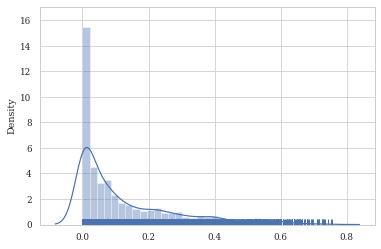

In [107]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

outliers greater than threshold 0.36978420682729385 is 579


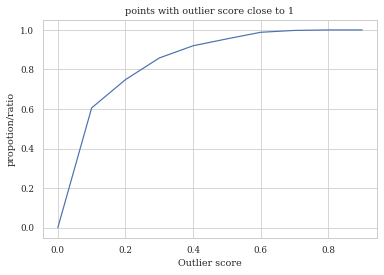

In [109]:
# Some of the clustered points show up very far away from the principal agglomeration, 
# and these should be handled by marking them as noise.
# 0 ->  algorithm is pretty sure that the location belongs to the cluster ; 1 -> noise 
scores = clusterer.outlier_scores_

threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

print('outliers greater than threshold {} is {}'.format(threshold,len(outliers)))

x = []
y = []

for i in np.arange(0,1,0.1):
  x.append(i) # outlier score
  y.append(scores[scores < i].shape[0] / scores.shape[0])

plt.plot(x, y)

plt.xlabel('Outlier score')
plt.ylabel('propotion/ratio')
plt.title('points with outlier score close to 1')
plt.grid(True)
# plt.savefig("test.png")
plt.show()

## removing outliers (beta)

In [226]:
# extract noise data

# extract index of noise and clusters
test = df.copy()
test['oulierScore'] = clusterer.outlier_scores_

noise = test.loc[test['hdbscan_Clusters']==-1]

threshold = pd.Series(clusterer.outlier_scores_).quantile(0.5)
print(threshold)

true_noise = noise.loc[noise['oulierScore'] > threshold]
idx_true_noise = true_noise.index

plt.scatter(*clusterable_embedding_2d.T, s=5, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*clusterable_embedding_2d[idx_true_noise].T, s=5, linewidth=0, c='red', alpha=0.5)

0.03815436218675154


In [231]:
# replace real noice with -2
df.loc[idx_true_noise, 'hdbscan_Clusters'] = -2

In [ ]:
# for distance calculation

columns = [f'col_{num}' for num in range(clusterable_embedding.shape[1])]
dataFrame = pd.DataFrame(clusterable_embedding, columns=columns)

# df[hdb] or clustere.labels?
dataFrame['Cluster'] = df['hdbscan_Clusters']
# dataFrame

In [269]:
noise = dataFrame.query('Cluster == -2').copy()
exemplars = dataFrame.query('Cluster != -2').copy()

# for distance calculation
noise_pro = noise.drop(['Cluster'], axis=1)
exemplars_pro = exemplars.drop(['Cluster'], axis=1)

from sklearn.metrics.pairwise import cosine_distances

distances = cosine_distances(noise_pro[['col_0','col_1','col_2','col_3','col_4']].values, exemplars_pro[['col_0','col_1','col_2','col_3','col_4']].values).squeeze()

In [275]:
exemplar_clusters = exemplars['Cluster'].values
noise['Cluster'] = [ exemplar_clusters[x.argmin()] for x in distances ]

NewDF = pd.concat([exemplars,noise])
NewDF.sort_index()

,col_0,col_1,col_2,col_3,col_4,Cluster
0,0.392917,3.396587,7.132086,7.050287,4.782413,10
1,2.121379,2.621793,8.005900,7.373054,3.439357,-1
2,1.451190,2.994843,7.685466,7.482423,4.428886,-1
3,1.063471,3.296938,8.418936,7.530745,2.596277,-1
4,0.226565,3.105428,8.149452,7.815600,2.526751,-1
...,...,...,...,...,...,...
5625,4.057284,5.441030,7.719392,7.858758,3.386243,2
5626,3.870543,4.906103,8.035272,7.528237,3.160302,2
5627,3.930906,5.277343,7.938167,7.799191,3.155051,2
5628,3.813709,5.097466,7.849075,7.784122,3.248636,2


In [ ]:
Counter(NewDF['Cluster'])

In [270]:
clusterer.labels_

array([ 6, -1,  6, ...,  2,  2,  2])

In [ ]:
df['hdbscan_Clusters']

In [ ]:
sample_df.sort_index(axis = 0) 

In [ ]:
# ?
scores[scores < 0.8].shape[0] / scores.shape[0]
# By selecting an outlier score threshold of 0.8, we retain over 97.85% of the cluster points.

In [ ]:
# filtering ?? just marking points as noise!!

filtered_clusters = np.copy(clusterer.labels_)
# matter of marking all outliers as noise
filtered_clusters[scores >= 0.8] = -1

## evaluation

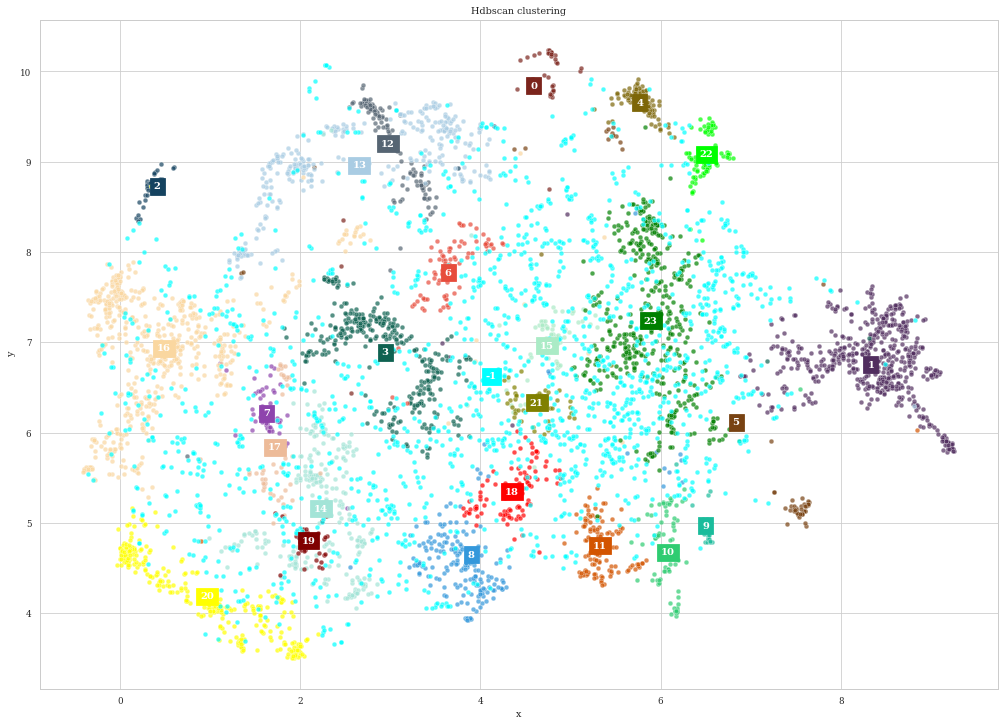

In [119]:
# plot with cluster labels, 27 colors in pallete

embed_df = pd.DataFrame(embedding2d, columns=['x', 'y'])
embed_df['label'] = labels
plt.figure(figsize=(14,10))
plt.title ('Hdbscan clustering')
plt.tight_layout()
for i,label in enumerate(list(set(labels))):
  #add data points 
  sns.scatterplot(x=embed_df.loc[embed_df['label']==label, 'x'], 
                y=embed_df.loc[embed_df['label']==label,'y'], 
                color=customPalette[i], 
                alpha=0.7)
    
  #add label
  plt.annotate(label, 
                 embed_df.loc[embed_df['label']==label,['x','y']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=10, weight='bold',
                 color='white',
                 backgroundcolor=customPalette[i]) 
  
plt.savefig("Hdbscan.svg", format="svg")


In [180]:
# with hover data! but custom 
fig2 = px.scatter(x=embedding2d[:,0], y=embedding2d[:,1], color=clusterer.labels_, 
                  hover_name=df.title, color_discrete_sequence=px.colors.qualitative.Plotly)


fig2.update_layout(template = 'plotly_white')
fig2.update_layout(title='axfdasf')
#fig2.show() # not showing!

# to upload to plotly web
# py.iplot(fig,filename,autoopen)

# to open in html
import plotly.io as pio
pio.write_html(fig2,file='index.html', auto_open=True)

In [ ]:
def matplotlib_to_plotly(cmap, pl_entries):
# Converts matplotlib colormap to plotly colormap. It also shuffles the color map

    h = 1.0/(pl_entries)
    pl_colorscale = []
    c_order = h * np.arange(pl_entries+1)
    c_order_shuffled = c_order.copy()
    # Shuffles the colormap
    np.random.shuffle(c_order_shuffled)
    for i in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(c_order_shuffled[i])[:3])*255))
        pl_colorscale.append([c_order[i], 'rgb'+str((C[0], C[1], C[2]))])
        # To have clear boundaries between colors in the colorbar
        if i < (pl_entries):
             pl_colorscale.append([c_order[i+1], 'rgb'+str((C[0], C[1], C[2]))])
    return pl_colorscale

# Sets the colormap of your choice , tab20, jet
cmap = matplotlib.cm.get_cmap('tab20')
# Passes the number of distinct colors you need to generate. In this case we have 10 cluster ids in stores_info_df
custom_colorscale = matplotlib_to_plotly(cmap, df_copy.category.max())

#custom_colorscale or use custom Pallete

fig3 = go.Figure(go.Scatter(x=embedding2d[:,0] , y=embedding2d[:,1], mode='markers', name='test name', 
                           marker=dict(color=clusterer.labels_, showscale=True,colorscale= customPalette )))
fig3.update_xaxes(title_text='x')
fig3.update_yaxes(title_text='y')

# to open in html
import plotly.io as pio
pio.write_html(fig3,file='index.html', auto_open=True)

In [ ]:
# Prepare data
# umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(train_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusterer.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=2, cmap='hsv_r')   # cmap custom Pallete
plt.colorbar()

<AxesSubplot:>

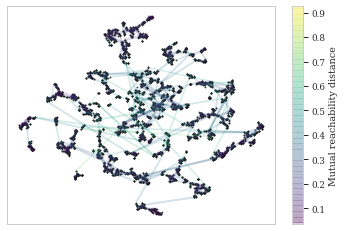

In [121]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.2, node_size=1, edge_linewidth=1)

<AxesSubplot:ylabel='distance'>

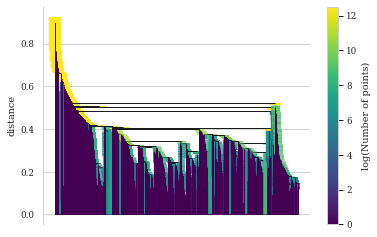

In [122]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

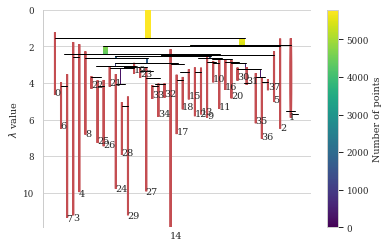

In [123]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette(),
                               label_clusters=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

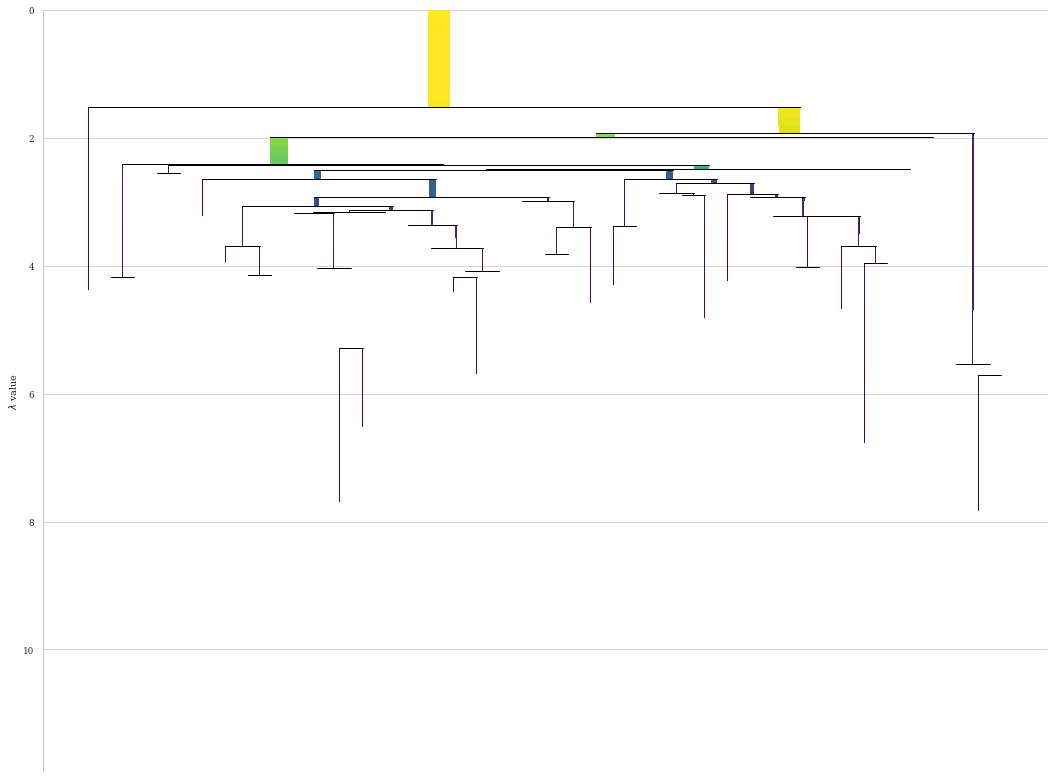

In [124]:
plt.figure(figsize=(18,14))
clusterer.condensed_tree_.plot(label_clusters=True,
                               colorbar=False, max_rectangles_per_icicle=3)

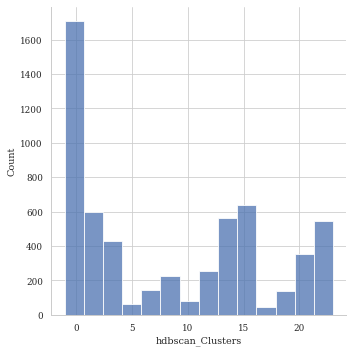

In [125]:
sns.displot(df['hdbscan_Clusters'])

/home/nomachine/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hdbscan_Clusters', ylabel='count'>

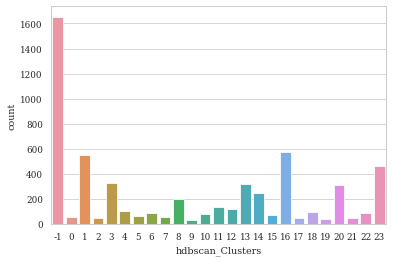

In [130]:
sns.countplot(df['hdbscan_Clusters'])

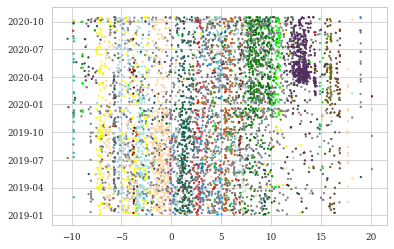

In [134]:
# umap1d with date
embedding1d = umap.UMAP(n_components=1,
                        n_neighbors=10,
                      min_dist=0,
                      metric='cosine').fit_transform(train_embeddings)

embeddingIdf = pd.DataFrame(embedding1d)
embeddingIdf.columns = ['x1']
embeddingIdf2 = pd.concat([embeddingIdf['x1'], df['date']],axis=1)

# sns.set_palette(customPalette, n_colors=100)

# color_palette = sns.color_palette('deep', 350)
cluster_colors = [customPalette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(embeddingIdf2['x1'], df['date'], c=cluster_member_colors,s=2)

In [ ]:
# date plot
sns.stripplot( x =embeddingIdf2['x1'], y=df['date'], jitter=True) # hue if needed

## umap visualization ?

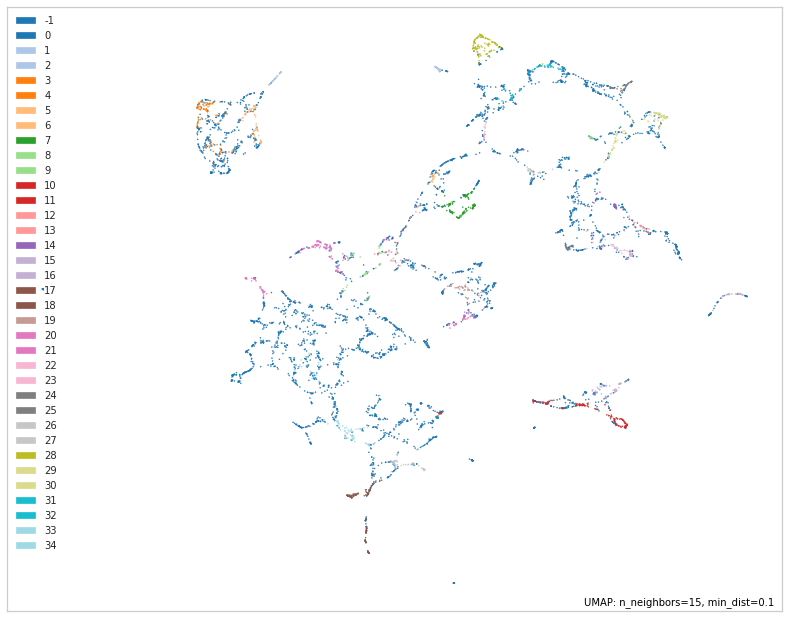

In [453]:


mapper = umap.UMAP().fit(embedding2d)

# labels???
p = umap.plot.points(mapper,labels=labels, width=1000, cmap =customPalette, theme ='blue')

# p = umap.plot.interactive(mapper, labels=labels, point_size=2, cmap=customPalette, theme ='blue')
# output_notebook()
# show(p)


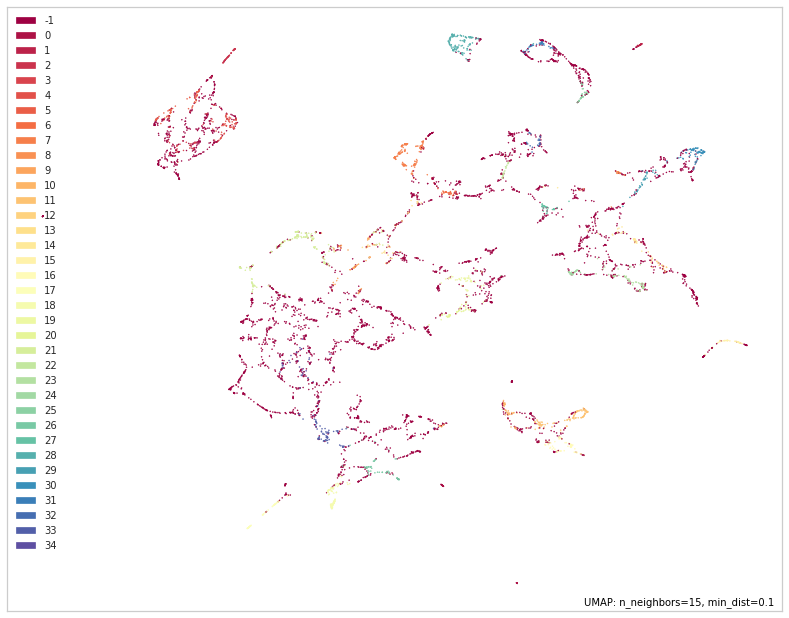

In [448]:
p = umap.plot.points(mapper,labels=labels, width=1000, cmap =customPalette)

In [ ]:

# matplot
clusterable_embedding = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(train_embeddings)


reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=2,
    random_state=42,)
reducer.fit(train_embeddings)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            s=0.1, cmap='Spectral')

labels = hdbscan.HDBSCAN(
    min_samples=50,
    min_cluster_size=50,
).fit_predict(clusterable_embedding)

clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
                    c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)

plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c = labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
# bokeh

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

embedding = reducer.transform(train_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

if (np.size(np.unique(labels)) - 2) < 0:
    colors = 0
else:
    colors = (np.size(np.unique(labels)) - 2)

df = pd.DataFrame(embedding, columns=('x', 'y'))
df['class'] = [str(x) for x in labels]

color_mapping = CategoricalColorMapper(factors=[str(colors - x) for x in np.unique(labels)],
                                       palette=Spectral10)

datasource = ColumnDataSource(df)

plot_figure = figure(
    title='UMAP projection',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='class', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)

show(plot_figure)


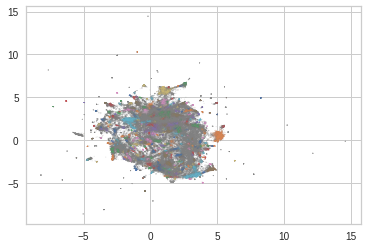

In [43]:
# hdbscan documentation visulaisation
color_palette = sns.color_palette('deep', 350)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*clusterable_embedding_2d.T, s=1, linewidth=0, c=cluster_member_colors, alpha=0.25)

# Time series

In [138]:
df_copy = df.copy()
df_copy.rename(columns={'hdbscan_Clusters':'category', 'title':'value'}, inplace = True)

In [140]:
from moda.dataprep import raw_to_ts

# df changes, hense df_copy was made
ts = raw_to_ts(df_copy)
ts.head()

,value,category,timestamp
date,,,
2019-01-17 00:00:00+00:00,Demo Charges Electric Vehicle from Hydrogen Fuel Cell,12,1547683200
2019-01-07 00:00:00+00:00,Fully integrated Industry 4.0 solution at Apex,-1,1546819200
2019-01-17 00:00:00+00:00,May Mobility's Self-Driving Shuttles Hit the Streets,-1,1547683200
2019-01-07 19:19:00+00:00,CES 2019: How employees can use Vuzix Blade AR Smart Glasses to optimize their workflow,20,1546888740
2019-01-08 00:00:00+00:00,"OhmniLabs Launches Supercam, a Telepresence Robot With Ultra-High Resolution",20,1546905600


In [141]:
## Some general stats

print("Dataset length: " + str(len(ts)))
print("Min date: " + str(ts.index.get_level_values('date').min()))
print("Max date: " + str(ts.index.get_level_values('date').max()))

print("Total time: {}".format(ts.index.get_level_values('date').max() - ts.index.get_level_values('date').min()))

print("Dataset contains {} categories.".format(len(ts['category'].unique())))

Dataset length: 5784
Min date: 2019-01-02 00:00:00+00:00
Max date: 2020-10-16 05:52:05+00:00
Total time: 653 days 05:52:05
Dataset contains 25 categories.


In [147]:
from moda.dataprep import ts_to_range
TIME_RANGE =  "2W" #"2M"                                     # Aggregate all events in the raw data into 3month intervals
ranged_ts = ts_to_range(ts,time_range=TIME_RANGE)
ranged_ts.head(20)
# value:  is the number of articles belonging to that particular category

value
date                      category       
2019-01-06 00:00:00+00:00 -1          7.0
                           2          2.0
                           3          3.0
                           8          5.0
                           13         1.0
                           14         1.0
                           16         1.0
                           17         1.0
                           18         1.0
                           20         3.0
                           23         1.0
2019-01-20 00:00:00+00:00 -1         35.0
                           0          2.0
                           1          1.0
                           2          0.0
                           3         12.0
                           4          1.0
                           5          1.0
                           6          1.0
                           7          1.0

In [148]:
display(cluster_slider)

from datetime import datetime                                

start_date = ts.index.get_level_values('date').min()
end_date = ts.index.get_level_values('date').max()

dates = pd.date_range(start_date, end_date, freq=TIME_RANGE)

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)


selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_range_slider

IntSlider(value=6, description='Cluster no:', max=23)

SelectionRangeSlider(description='Dates', index=(0, 46), layout=Layout(width='500px'), options=((' 06 Jan 2019…

<AxesSubplot:title={'center':'Number of mentions for 1'}, xlabel='date'>

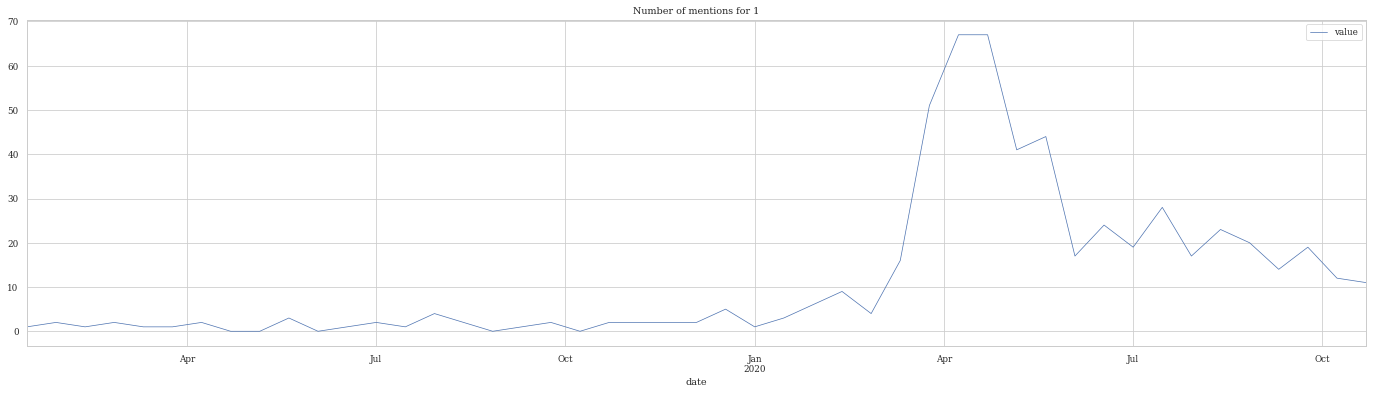

In [149]:
# growth of particular category/cluster
category = cluster_slider.value
ranged_ts.loc[pd.IndexSlice[:, category], :].reset_index().plot(kind='line',x='date',y='value',figsize=(24,6),linewidth=0.7, 
                          title = "Number of mentions for {}".format(category))

In [ ]:
#cahnge delta t and custom date
# from moda.dataprep.ts_to_range import ts_to_range
from moda.dataprep import ts_to_range


ranged_ts_3H = ts_to_range(ts,time_range='1M',pad_with_zeros=True)
ranged_ts_30min = ts_to_range(ts,time_range='2W',pad_with_zeros=True)

START = '2015-11-01'
END = '2019-01-01'
category = 2

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,12))

cleaning_30min = ranged_ts_30min.loc[pd.IndexSlice[:, category], :].reset_index()
a1=cleaning_30min[(cleaning_30min.date > START) & (cleaning_30min.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[0])

cleaning_3H = ranged_ts_3H.loc[pd.IndexSlice[:, category], :].reset_index()
a2=cleaning_3H[(cleaning_3H.date > START) & (cleaning_3H.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[1])

cleaning_24H = ranged_ts.loc[pd.IndexSlice[:, category], :].reset_index()
a3=cleaning_24H[(cleaning_24H.date > START) & (cleaning_24H.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[2])

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 612 kB 10.1 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Filtered dataset contains 25 categories,
after filtering the small ones that existed less than 10 days or had 5 values of less.


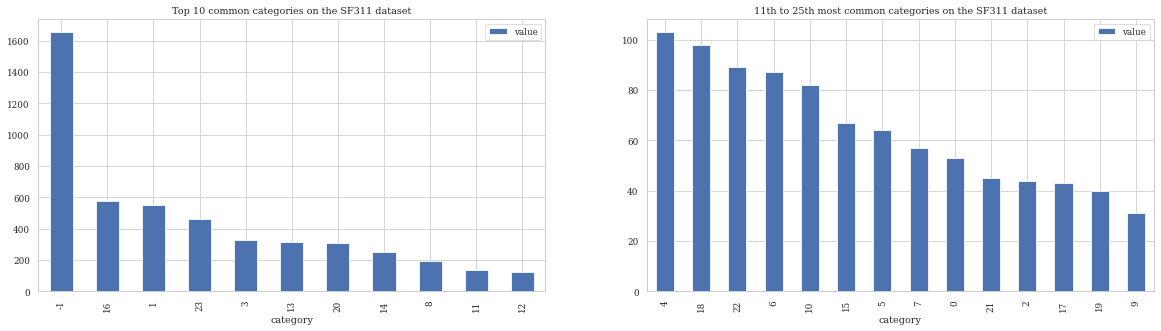

In [151]:
# common categories

!pip install dfply
from dfply import *
import matplotlib.pyplot as plt
## Remove categories with less than 1000 items (in more than 10 years) or that existed less than 100 days
min_values = 5
min_days = 10

categories = ranged_ts.reset_index() >> group_by(X.category) >> \
    summarise(value = np.sum(X.value),duration_in_dataset = X.date.max()-X.date.min()) >> \
    ungroup() >> \
    mask(X.duration_in_dataset.dt.days > min_days) >> \
    mask(X.value > min_values) >> \
    arrange(X.value,ascending=False)



print("Filtered dataset contains {0} categories,\nafter filtering the small ones that existed less than {1} days or had {2} values of less.".
      format(len(categories),min_days,min_values))

categories.head()

category_names = categories['category'].values
num_categories = len(categories)

major_category_threshold=11
major_categories = category_names[:major_category_threshold]
minor_categories = category_names[major_category_threshold:]

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(20)

categories[categories['category'].isin(major_categories)].plot(kind='bar',
                                                               x='category',
                                                               y='value',
                                                               title="Top "+str(major_category_threshold-1)+" common categories on the SF311 dataset",
                                                               ax=axes[0])
categories[categories['category'].isin(minor_categories)].plot(kind='bar',
                                                               x='category',
                                                               y='value',
                                                               title=str(major_category_threshold)+"th to "+str(num_categories)+"th most common categories on the SF311 dataset",
                                                               ax=axes[1])

plt.savefig("category_values.png",bbox_inches='tight')

/home/nomachine/.local/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/nomachine/.local/lib/python3.8/site-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


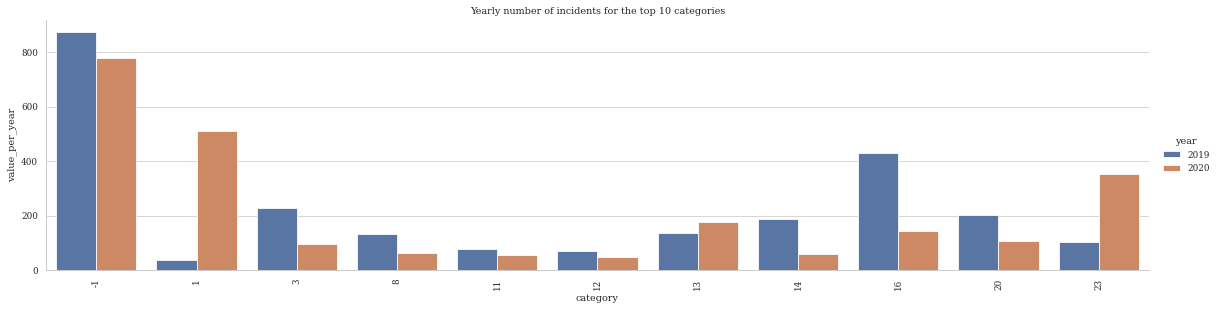

In [152]:
## Calculate the number of values per category per year !!! do for monthly
categories_yearly = ranged_ts.reset_index() >> mutate(year = X.date.dt.year) >> group_by(X.category,X.year) >> \
    summarise(value_per_year = np.sum(X.value),
              duration_in_dataset = X.date.max()-X.date.min()) >>\
    ungroup() >> \
    mask(X.value_per_year > (min_values/12.0)) >> \
    arrange(X.value_per_year,ascending=False)

import seaborn as sns

major_cats_yearly = categories_yearly[categories_yearly['category'].isin(major_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=major_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the top "+str(major_category_threshold-1)+" categories")
plt.savefig("yearly_values.png",bbox_inches='tight')

# Sumarization

In [153]:
import yake

import spacy
# en_core_web_sm not working!
nlp = spacy.load("en")
import pytextrank

from keybert import KeyBERT

# add PyTextRank to the spaCy pipeline
tr = pytextrank.TextRank()
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

# Yake
language = "en"
max_ngram_size = 3
deduplication_thresold = 0.9
deduplication_algo = 'seqm'
windowSize = 4                    # <----
numOfKeywords = 10

kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)


# keybert
Keybert_model = KeyBERT('distilbert-base-nli-mean-tokens')

In [203]:
display(cluster_slider)

algorithm_radio_button = widgets.RadioButtons(
    options=['TextRank', 'Yake', 'KeyBert'], value='TextRank',description='Algorithm:',disabled=False)
display(algorithm_radio_button)

selection_range_slider

IntSlider(value=13, description='Cluster no:', max=23)

RadioButtons(description='Algorithm:', options=('TextRank', 'Yake', 'KeyBert'), value='TextRank')

SelectionRangeSlider(description='Dates', index=(0, 46), layout=Layout(width='500px'), options=((' 06 Jan 2019…

In [206]:
begin = str(selection_range_slider.value[0])[:10]
end = str(selection_range_slider.value[1])[:10]

# selected_articles = df.loc[(df.hdbscan_Clusters == cluster_slider.value) & (df.date < end) & (df.date > begin) ]
selected_articles = df_copy.loc[(df_copy.category == cluster_slider.value) & (df_copy.index < end) & (df_copy.index > begin) ]

text = '.'.join(selected_articles.value)  # join all to single list

if algorithm_radio_button.value == 'TextRank':
  doc = nlp(text)
  for p in doc._.phrases:
    print("{}  {:.4f} {:5d} ".format(p.text,p.rank, p.count))

elif algorithm_radio_button.value == 'KeyBert':
  print(Keybert_model.extract_keywords(text,stop_words='english'))

else:
  keywords = kw_extractor.extract_keywords(text)
  for kw in keywords:
	  print(kw)
   
text

['photovoltaics', 'remodeling', 'solarsmart', 'renewables', 'photovoltaic']


'Using drones to tackle climate change.Digital Modular Cleaner Offers Design and Process Flexibility.Encapsulated railway converters with pure convection cooling.Roof-mounted energy efficient cooling units.New catalysts for better fuel cells.Windshield Wipers could Help Prevent Flooding, Says U-M Study.New Oil and Gas Report Reveals Digital Foundations in Place.These utilities plan to add solar and energy storage capacity.How connected vehicles\' windshield wipers could prevent flooding.Good Road Pavements Reduce Greenhouse Gas Emissions.A Lack of Minerals Is Threatening America\'s Energy Future.Ikea creates curtains that act as home air purifiers.New Membrane Water Treatment System to Reduce Toxic Waste by Over 90 Percent.Concrete Answer: How the Industry Is Dealing with Excessive Emissions.Energy storage for uninterruptible power supply.Scientists Develop First Fabric to Automatically Cool or Insulate Depending on Conditions.Modern Heat Treat expands capability with AFC-Holcroft furn

In [210]:
# df.loc[(df.hdbscan_Clusters == cluster_slider.value) & (df.index < end) & (df.index > begin) ].sort_values(by=['date'])
result = df.query('hdbscan_Clusters == @cluster_slider.value')
print('number of articles :', len(result))
result

number of articles : 315


,date,title,hdbscan_Clusters
47,2019-01-09 00:00:00+00:00,Using drones to tackle climate change,13
59,2019-01-07 00:00:00+00:00,Digital Modular Cleaner Offers Design and Process Flexibility,13
71,2019-01-10 00:00:00+00:00,Encapsulated railway converters with pure convection cooling,13
72,2019-01-31 00:00:00+00:00,Roof-mounted energy efficient cooling units,13
83,2019-01-09 00:00:00+00:00,New catalysts for better fuel cells,13
...,...,...,...
5455,2020-10-16 05:52:05+00:00,INDIANA MICHIGAN POWER Solar Panel Installation Underway at St. Joseph Solar Farm,13
5465,2020-10-13 00:00:00+00:00,GEOTHERMAL DEVELOPMENT COMPANY GDC mobilizes 2nd drilling rig to Baringo-Silali geothermal project in Kenya,13
5468,2020-10-16 05:51:02+00:00,"CENTERPOINT ENERGY, INC. CenterPoint Energy offers Minnesota businesses an online tool to measure and manage their energy use Energy benchmarking can help businesses reduce their carbon footprint, one building at a time",13
5659,2020-06-09 15:45:00+00:00,TBRC COVID-Impact Report Insights: Growing Demand For Ethyl Alcohol-based Sanitizers,13


In [ ]:
# different keyBER setting

In [171]:
df.info()
# !ls
# %cd visulaization/

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 951 entries, 2019-01-07 00:00:00 to 2019-01-09 00:00:00
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   value            951 non-null    object
 1   text             951 non-null    object
 2   sitename         951 non-null    object
 3   category         951 non-null    int64 
 4   kmedoi_Clusters  951 non-null    int64 
 5   timestamp        951 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 72.0+ KB


In [173]:
# export for visualisation

np.savetxt('out.tsv', clusterable_embedding ,delimiter='\t')

tit = df_copy.category
# Save dataframe without any index
tit.to_csv('metadata.tsv', index=False, sep='\t', header=False)

# https://projector.tensorflow.org/

In [175]:
#  2D/

# d2_embedding = umap.UMAP(n_neighbors=5,min_dist=0.1,n_components=2,random_state=42,metric='cosine'
# ).fit_transform(train_embeddings)

np.savetxt('out.tsv', embedding2d ,delimiter='\t')

/home/nomachine/Documents/TrendDetection/Rokin/visulaization/2D


In [ ]:
# !pip install chart_studio

In [ ]:
# plotly
import chart_studio
chart_studio.tools.set_credentials_file(username='jishnuJJ' , api_key='PN0sb8uFKnHNQTY76W41' )

import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px

# text
fig = go.Figure(go.Scatter(x=embedding2d[:,0] , y=embedding2d[:,1], mode='markers', name='test name', 
                           marker=dict(color=clusterer.labels_, showscale=True,colorscale='Viridis')))
fig.update_xaxes(title_text='x')
fig.update_yaxes(title_text='y')

py.iplot(fig, filename='scatter-951')

In [ ]:
# preating color scale
import matplotlib



In [4]:
print(plotly.io.orca.config)

orca configuration
------------------
    server_url: None
    executable: orca
    port: None
    timeout: None
    default_width: None
    default_height: None
    default_scale: 1
    default_format: png
    mathjax: https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js
    topojson: None
    mapbox_access_token: None
    use_xvfb: auto

constants
---------
    plotlyjs: /home/nomachine/.local/lib/python3.8/site-packages/plotly/package_data/plotly.min.js
    config_file: /home/nomachine/.plotly/.orca




In [1]:
# saving, svg, pdf, jpeg..
# !pip install plotly plotly-orca
import plotly


# plotly.io.orca.config.executable ='/home/nomachine/Downloads/orca-executable.sh'
plotly.io.write_image(fig3,"image956.svg")

NameError: ignored